# Liquid Cooling Market Watch

## Automated Analysis of Liquid Cooling Technology Providers and Adopters


## Why It Matters

The rapid growth of AI and high-performance computing is driving unprecedented energy demands in data centers, making efficient cooling solutions critical for operational sustainability and cost management. Traditional air cooling is reaching its limits, creating opportunities for liquid cooling technology providers and early adoption advantages for data center operators, but tracking these developments across fragmented industry coverage is challenging for investment decisions.

## What It Does

Using the functions available in the bigdata-research-tools package, you can create a comprehensive liquid cooling ecosystem analysis tool that identifies technology providers, tracks customer adoption patterns, and maps provider-customer relationships using unstructured data from news sources. These functions are suitable for technology analysts, infrastructure investors, and industry professionals to create tools that transform scattered technology signals into quantified market intelligence and identify investment opportunities in the cooling technology value chain.

## How It Works

This workflow combines **dual-role classification**, **network analysis**, and **temporal tracking** to deliver:

- **Provider vs. adopter identification** distinguishing companies developing liquid cooling solutions from those implementing them
- **Technology ecosystem mapping** revealing relationships between solution providers and data center operators
- **Adoption timeline tracking** showing how liquid cooling implementation evolves across different sectors
- **Market positioning analysis** quantifying each company's role and exposure in the liquid cooling ecosystem

## A Real-World Use Case

This cookbook demonstrates the complete workflow through analyzing liquid cooling technology dynamics across the data center industry using news data, showing how the system automatically identifies technology leaders, tracks customer adoption patterns, and reveals provider-customer networks through automated relationship analysis.

## Setup and Imports

## Async Compatibility Setup

**Run this cell first** - Required for Google Colab, Jupyter Notebooks, and VS Code with Jupyter extension:

### Why is this needed?

Interactive environments (Colab, Jupyter) already have an asyncio event loop running. When bigdata-research-tools makes async API calls (like to OpenAI), you'll get this error without nest_asyncio:

```
RuntimeError: asyncio.run() cannot be called from a running event loop
```

The `nest_asyncio.apply()` command patches this to allow nested event loops.

💡 **Tip**: If you're unsure which environment you're in, just run the cell below - it won't hurt in any environment!

In [2]:
import datetime
start = datetime.datetime.now()

In [3]:
try:
    import asyncio
    asyncio.get_running_loop()
    import nest_asyncio; nest_asyncio.apply()
    print("✅ nest_asyncio applied")
except (RuntimeError, ImportError):
    print("✅ nest_asyncio not needed")

✅ nest_asyncio applied


## Environment Setup

The following cell configures the necessary path for the analysis

In [4]:
import os
import sys

current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)
print(f"✅ Local environment setup complete")

✅ Local environment setup complete


## Import Required Libraries

Below is the Python code required for setting up our environment and importing necessary libraries.

In [5]:
import pandas as pd

from src.tool import plot_top_companies_by_sector, transform_to_reference_format, identify_basket_and_plot_confidence, analyze_basket_with_labels
from src.search import search_cooling
from src.labeling import run_liquid_cooling_prompt
from src.network_analysis import provider_adopter_net

from bigdata_client import Bigdata
from bigdata_client.models.search import DocumentType
from bigdata_research_tools.excel import ExcelManager

## Optional: Plotly Display Configuration

For better visualization rendering, you can also set the Plotly renderer:

In [6]:
import plotly.io as pio
import plotly.graph_objects as go

# Try to detect the environment and set appropriate renderer
try:
    # Check if we're in JupyterLab
    import os
    if 'JUPYTERHUB_SERVICE_PREFIX' in os.environ or 'JPY_SESSION_NAME' in os.environ:
        pio.renderers.default = 'jupyterlab'
        print("✅ Plotly configured for JupyterLab")
    else:
        # Default for VS Code, Jupyter Notebook, etc.
        pio.renderers.default = 'plotly_mimetype+notebook'
        print("✅ Plotly configured for Jupyter/VS Code")
except:
    # Fallback to a more universal renderer
    pio.renderers.default = 'notebook'
    print("✅ Plotly configured with fallback renderer")

✅ Plotly configured for Jupyter/VS Code


## Define Output Paths

We define the output paths for our liquid cooling analysis results.

In [7]:
# Define output file paths for our results
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

export_path = f"{output_dir}/liquid_cooling_analysis_results.xlsx"

## Load Credentials

In [8]:
from dotenv import load_dotenv
from pathlib import Path

script_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
load_dotenv(script_dir / '.env')

BIGDATA_USERNAME = os.getenv('BIGDATA_USERNAME')
BIGDATA_PASSWORD = os.getenv('BIGDATA_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

if not all([BIGDATA_USERNAME, BIGDATA_PASSWORD, OPENAI_API_KEY]):
    print("❌ Missing required environment variables")
    raise ValueError("Missing required environment variables. Check your .env file.")
else:
    print("✅ Credentials loaded from .env file")

✅ Credentials loaded from .env file


## Connecting to Bigdata

Create a Bigdata object with your credentials.

In [9]:
bigdata = Bigdata(BIGDATA_USERNAME, BIGDATA_PASSWORD)

## Defining your Liquid Cooling Analysis Parameters


### Fixed Parameters
-  **Provider Theme** (`provider_theme`): The central concept to explore for liquid cooling technology providers
-  **Adopter Theme** (`adopter_theme`): The concept to explore for companies adopting liquid cooling in their data centers
- **Provider Sentences** (`provider_sentences_list`): Sentences used to identify companies providing liquid cooling solutions
- **Adopter Sentences** (`adopter_sentences_list`): Sentences used to identify companies adopting liquid cooling technology
-  **Document Type** (`document_type`): Specify which documents to search over
   (transcripts, filings, news)


### Customizable Parameters
-  **Watchlist** (`my_watchlist_id`): The set of companies to analyze. This is the ID of your watchlist on https://app.bigdata.com/watchlists. If set to `None`, each company referenced in the retrieved chunks will be analyzed.
-  **Model Selection** (`llm_model`): The LLM model used to label search result document chunks and generate summaries
-  **Frequency** (`freq`): The frequency of the date ranges to search over.
   Supported values:

   -  `Y`: Yearly intervals.
   -  `M`: Monthly intervals.
   -  `W`: Weekly intervals.
   -  `D`: Daily intervals. Defaults to `M`.

-   **Time Period** (`start_date` and `end_date`): The date range over which to
   run the analysis

-  **Document Sources** (`sources`): Specify set of sources within a document type, for
   example which news outlets (available via Bigdata API) you wish to
   search over

-  **Rerank Threshold** (`rerank_threshold`): By setting this value, you're
   enabling the cross-encoder which reranks the results and selects
   those whose relevance is above the percentile you specify (0.7 being
   the 70th percentile). More information on the re-ranker can be found
   [here](https://sdk.bigdata.com/en/latest/how_to_guides/rerank_search.html).

-  **Model Selection** (`llm_model`): The LLM model used to label the search result chunks

-  **Document Limit** (`document_limit`): The maximum number of documents to
   return per query to Bigdata API

-  **Batch Size** (`batch_size`): The number of entities to include in a
   single batched query

In [10]:
# ===== Fixed Parameters =====

# Liquid Cooling Provider Theme
provider_theme = "The target company only is a provider of liquid cooling technology for data centers, not an adopter"

# Liquid Cooling Adopter Theme  
adopter_theme = "The target company is an adopter of liquid cooling technology for data centers, not a provider"

# Sentences expressing liquid cooling provider narratives
provider_sentences_list = [
    'Company develops liquid cooling systems for data centers',
    'Firm manufactures liquid cooling solutions for servers',
    'Organization provides immersion cooling technology',
    'Corporation supplies water cooling systems for data centers',
    'Company offers liquid cooling infrastructure solutions',
    'Business develops advanced liquid cooling technology',
    'Enterprise manufactures server liquid cooling systems',
    'Firm provides data center cooling solutions',
    'Company creates liquid cooling products for servers',
    'Organization designs immersion cooling systems',
    'Corporation develops water cooling technology',
    'Business supplies liquid cooling equipment',
    'Enterprise offers advanced cooling solutions for data centers',
    'Company produces liquid cooling infrastructure',
    'Firm develops innovative cooling technology',
    'Organization manufactures liquid cooling hardware',
    'Corporation provides cooling system integration',
    'Business creates data center cooling products',
    'Enterprise develops liquid cooling platforms',
    'Company supplies advanced cooling systems',
    'Firm offers liquid cooling consulting services',
    'Organization provides cooling technology solutions',
    'Corporation develops liquid cooling innovations',
    'Business manufactures cooling system components',
    'Enterprise offers liquid cooling design services'
]

# Sentences expressing liquid cooling adoption narratives
adopter_sentences_list = [
    'Company adopts liquid cooling in data centers',
    'Firm implements liquid cooling technology',
    'Organization installs immersion cooling systems',
    'Corporation deploys water cooling in data centers',
    'Company uses liquid cooling for servers',
    'Business adopts advanced cooling technology',
    'Enterprise implements liquid cooling infrastructure',
    'Firm installs liquid cooling systems',
    'Company deploys immersion cooling technology',
    'Organization uses water cooling systems',
    'Corporation adopts liquid cooling solutions',
    'Business implements advanced cooling systems',
    'Enterprise deploys liquid cooling in facilities',
    'Company installs advanced cooling technology',
    'Firm uses liquid cooling infrastructure',
    'Organization implements cooling system upgrades',
    'Corporation adopts immersion cooling systems',
    'Business deploys liquid cooling solutions',
    'Enterprise uses advanced cooling technology',
    'Company implements liquid cooling in operations',
    'Firm adopts cooling system innovations',
    'Organization deploys advanced cooling infrastructure',
    'Corporation uses liquid cooling for efficiency',
    'Business implements cooling technology upgrades',
    'Enterprise adopts liquid cooling systems'
]

# Document Configuration
document_type = DocumentType.NEWS

In [11]:
# ===== Customizable Parameters =====

# Company Universe (from Watchlist)
my_watchlist_id = None # Replace with your watchlist ID
if my_watchlist_id is not None:  
    watchlist = bigdata.watchlists.get(my_watchlist_id)
    companies = bigdata.knowledge_graph.get_entities(watchlist.items)
else:
    companies = None

# LLM Specification
llm_model = "openai::gpt-4o-mini"

# Search Frequency
search_frequency = 'M'

# Enable/Disable Reranker
rerank_threshold = None

# Specify Time Range
start_date = "2021-01-01"
end_date = "2024-06-30"

# Document Limits
document_limit = 15

# Others
batch_size = 10

## Retrieve Content using Bigdata's Search Capabilities

With the liquid cooling narratives and analysis parameters, you can leverage the
Bigdata API to run a search on company news for both provider and adopter indicators.

In [11]:
df_sentences_provider = search_cooling(
    sentences=provider_sentences_list,
    start_date=start_date,
    end_date=end_date,
    scope=document_type,
    rerank_threshold=rerank_threshold,
    freq=search_frequency,
    document_limit=document_limit,
    batch_size=batch_size,
    keywords=["liquid cooling","data center"]
)

df_sentences_adopter = search_cooling(
    sentences=adopter_sentences_list,
    start_date=start_date,
    end_date=end_date,
    scope=document_type,
    rerank_threshold=rerank_threshold,
    freq=search_frequency,
    document_limit=document_limit,
    batch_size=batch_size,
    keywords=["liquid cooling","data center"]
)

df_all = pd.concat([df_sentences_provider, df_sentences_adopter], ignore_index=True)
df_all = df_all.drop_duplicates(subset=['document_id', 'sentence_id', 'headline', 'entity_id', 'entity_name', 'text'])


Processing news results...: 100%|██████████| 15750/15750 [00:00<00:00, 72579.69it/s]


In [12]:
df_all = df_all.rename(columns={
            'entity_id': 'rp_entity_id',
            'document_id': 'rp_document_id',
        })
df_all_labeled = run_liquid_cooling_prompt(
            sentences=df_all,
            masked_2=True,
            batch_size=10, 
            open_ai_credentials=OPENAI_API_KEY)

100%|██████████| 727/727 [00:47<00:00, 15.27it/s]


In [13]:
df_all_labeled_transform = transform_to_reference_format(df_all_labeled)
df_providers = df_all_labeled_transform[df_all_labeled_transform["label"] == "P"].copy()
df_providers.reset_index(drop=True, inplace=True)
df_adopters = df_all_labeled_transform[df_all_labeled_transform["label"] == "A"].copy()
df_adopters.reset_index(drop=True, inplace=True)

## Visualizations

## Sector-Based Liquid Cooling Technology Visualization

The following visualizations provide a sector-by-sector breakdown of companies involved in liquid cooling technology. These charts help identify:

- **Industry Patterns**: Which sectors show more liquid cooling activity
- **Technology Leaders**: Companies most frequently mentioned in liquid cooling contexts within each sector  
- **Story Context**: Detailed hover information reveals the specific headlines, motivations, and news excerpts driving each company's positioning

Each bar represents the frequency of liquid cooling mentions, with hover details providing the underlying news narrative that shaped each company's role in the liquid cooling ecosystem.

### Companies Providing Liquid Cooling Solutions

This chart displays companies that have been most frequently mentioned as providers of liquid cooling technology, organized by sector and ranked by total mention volume. The visualization reveals which companies and industries are leading the development and supply of liquid cooling solutions for data centers, including system manufacturers, technology developers, and solution integrators.

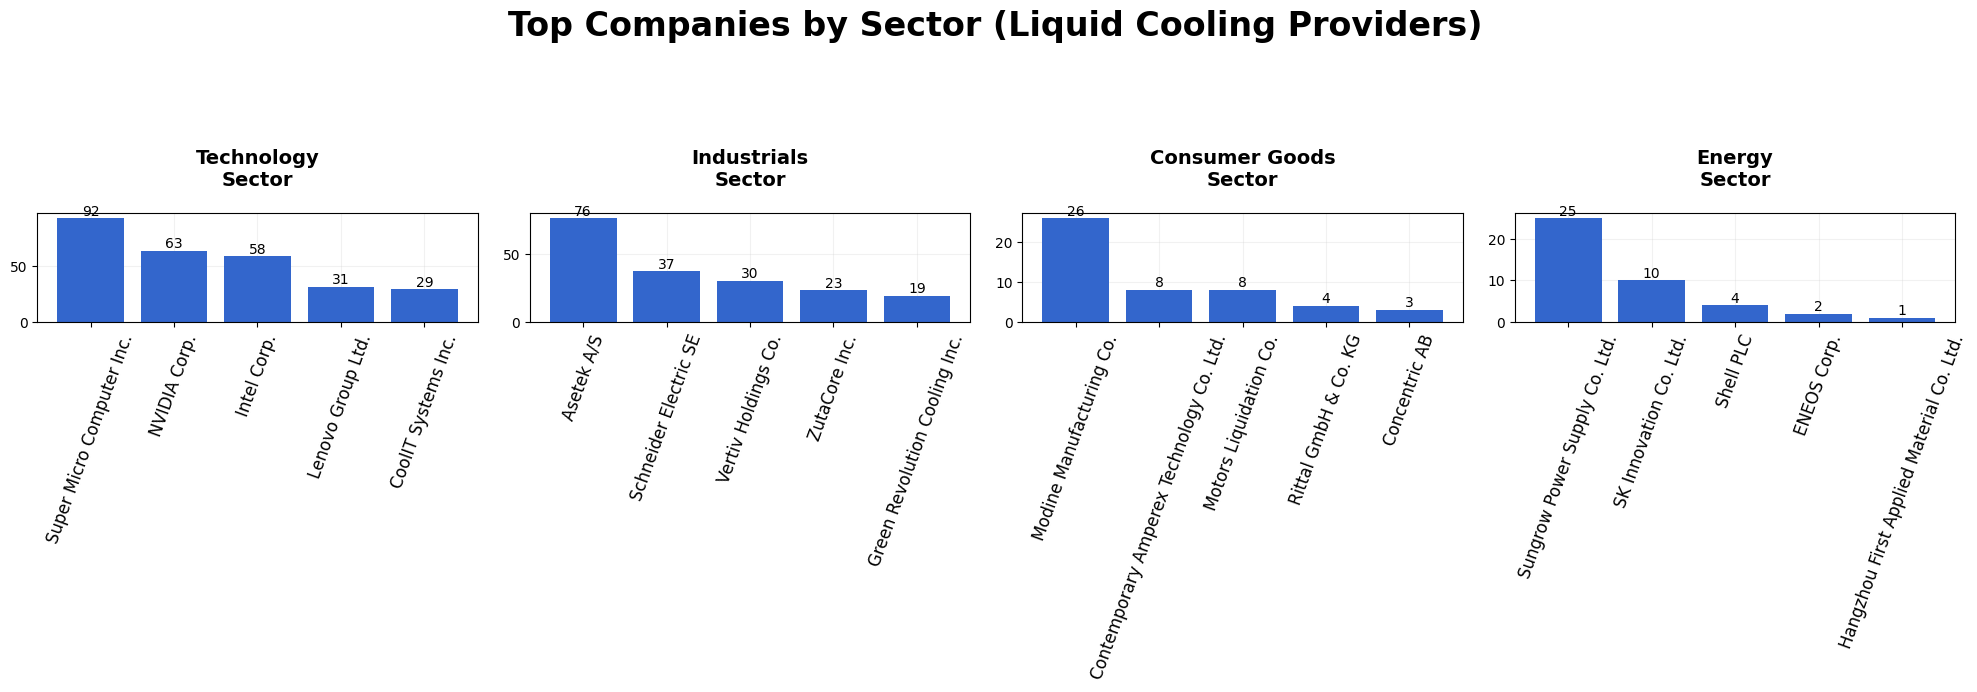

In [ ]:
plot_top_companies_by_sector(df_providers, min_companies=1, title_suffix="(Liquid Cooling Providers)", top_sectors=4, interactive=True)

### Companies Adopting Liquid Cooling Technology

This complementary chart shows companies most frequently mentioned as adopters of liquid cooling technology in their data centers, organized by sector and ranked by total mention volume. It identifies firms investing in liquid cooling infrastructure, implementing new cooling systems, or upgrading their data center operations to improve energy efficiency and performance.

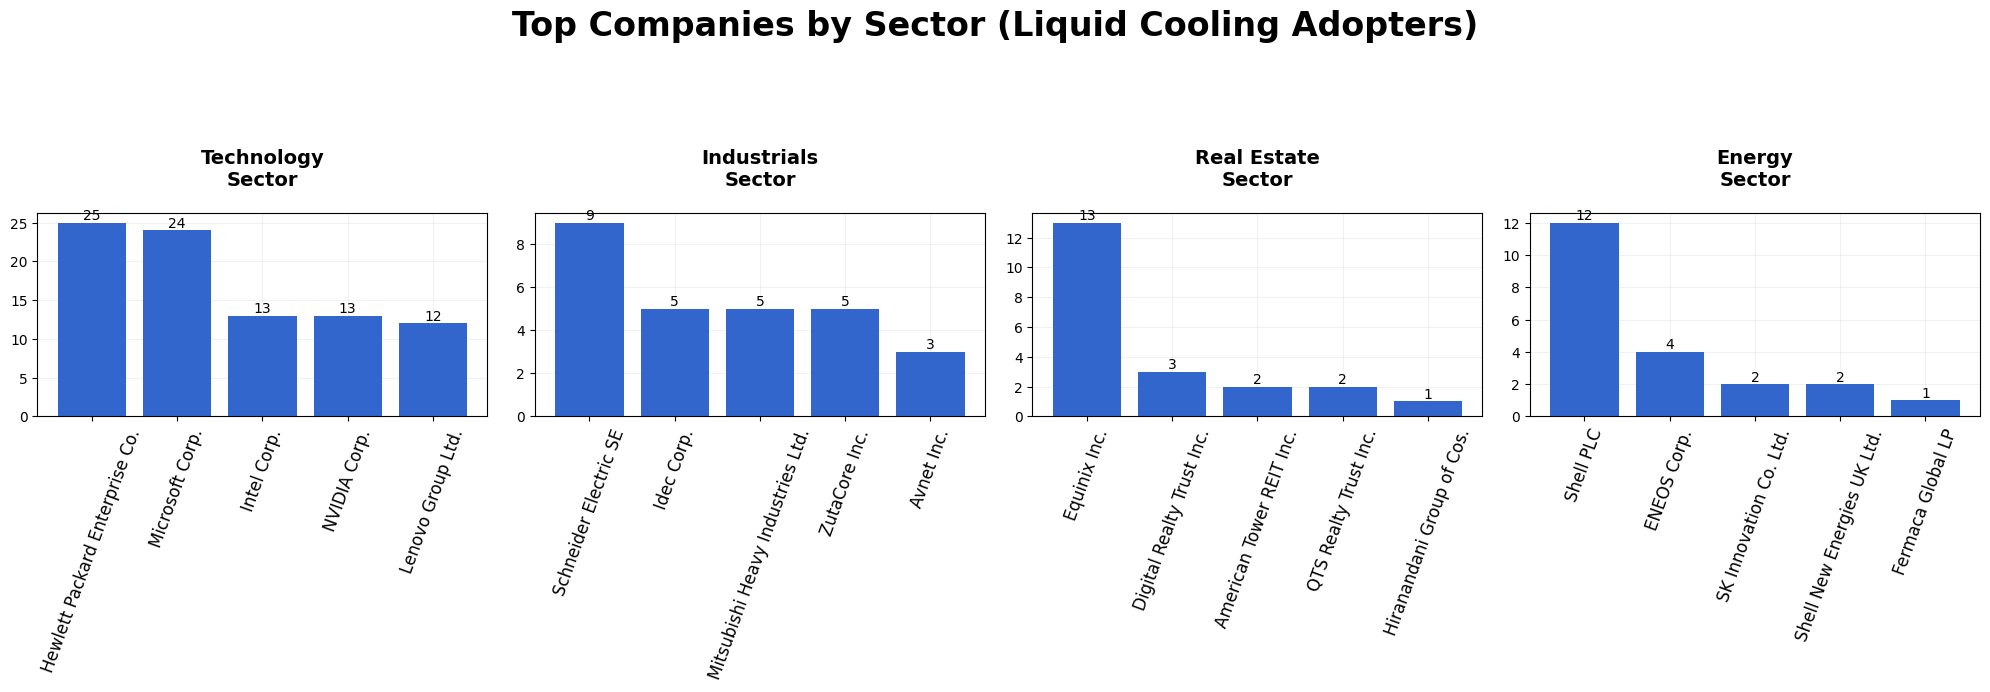

In [23]:
plot_top_companies_by_sector(df_adopters, min_companies=1, title_suffix="(Liquid Cooling Adopters)", top_sectors=4, interactive=True)

## Liquid Cooling Ecosystem Analysis

This comprehensive assessment combines both provider and adopter signals to create a complete picture of the liquid cooling ecosystem. The analysis provides:

- **Total Exposure**: Overall volume of liquid cooling related news coverage for each company
- **Role Classification**: Relative proportion of provider versus adopter mentions  
- **Market Positioning**: How companies rank in terms of their involvement in the liquid cooling market

The stacked bar chart shows the percentage breakdown of provider (green) versus adopter (red) mentions for the top 40 most-mentioned companies. Companies with predominantly blue bars are primarily technology providers, while those with green bars are mainly end-users implementing liquid cooling solutions.

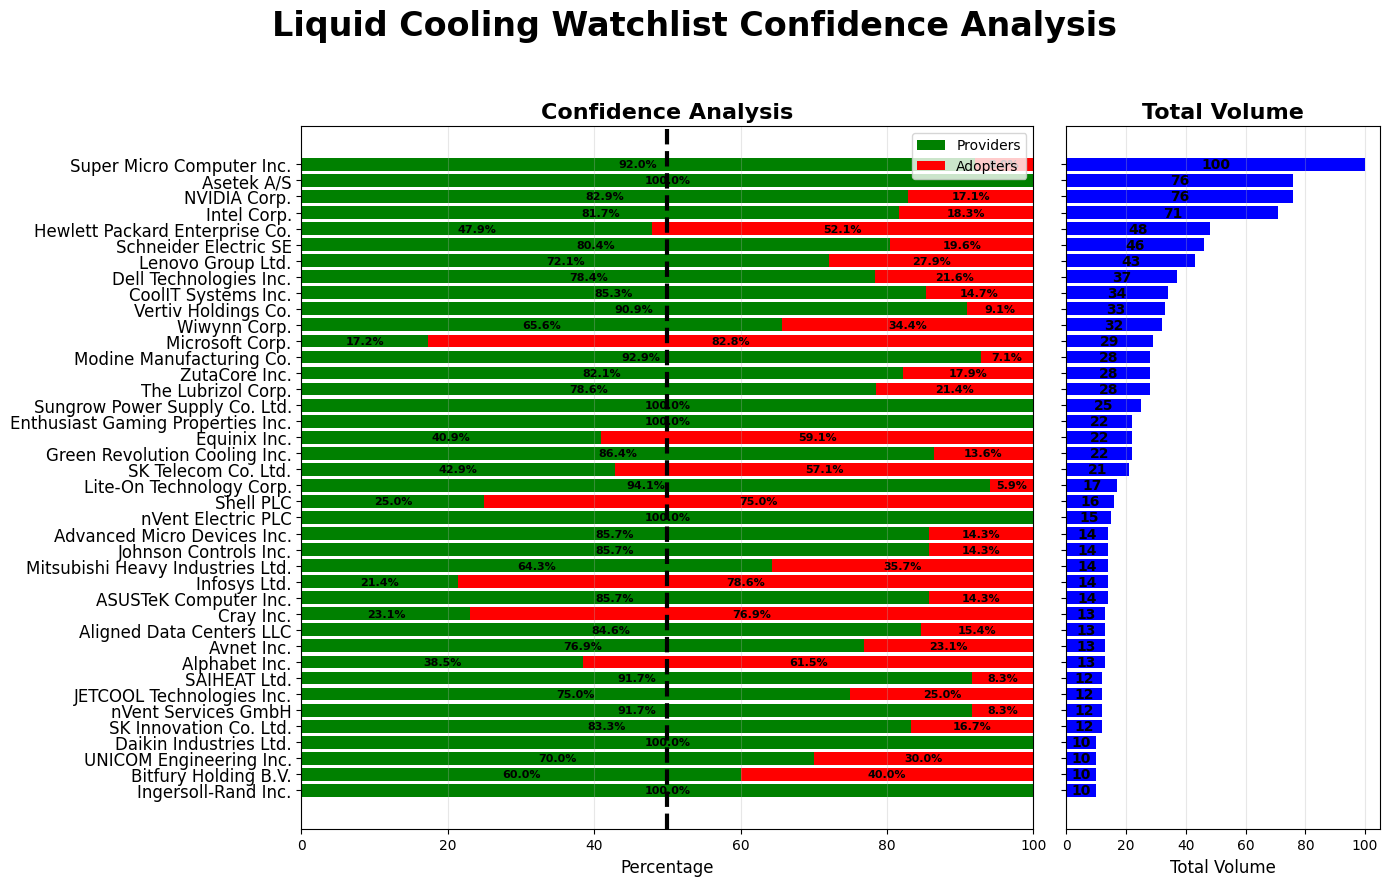

In [ ]:
companies_basket = identify_basket_and_plot_confidence(df_providers,df_adopters, basket_size=40, theme_name='Liquid Cooling', positive_label='Providers', negative_label='Adopters', interactive=True)

In [17]:
companies_basket.head()

,Company,positive_exp,negative_exp,total_exposure,Sector,positive_exp_pct,negative_exp_pct,headline_positive_exp,text_positive_exp,motivation_positive_exp,headline_negative_exp,text_negative_exp,motivation_negative_exp
0,Ingersoll-Rand Inc.,10.0,0.0,10.0,Industrials,100.000000,0.000000,APAC Data Center Market Size to Reach Revenues...,Other Prominent Data Center Support Infrastruc...,Target Company is listed among prominent data ...,,,
1,Bitfury Holding B.V.,6.0,4.0,10.0,Technology,60.000000,40.000000,Immersion Cooling Innovator LiquidStack Enters...,Bitfury is also a software provider for some o...,Target Company is a provider of high-quality c...,Spinning out from the cryptocurrency hardware ...,It was first acquired by Bitfury in 2015 after...,Target Company mentions the deployment of imme...
2,UNICOM Engineering Inc.,7.0,3.0,10.0,Technology,70.000000,30.000000,UNICOM Engineering Revolutionizes Data Center ...,"CANTON, Mass., Dec. 27, 2023 (GLOBE NEWSWIRE) ...",Target Company is expanding its portfolio of i...,TMGcore and UNICOM Engineering Announce Intel ...,TMGcore and UNICOM Engineering win Intel Innov...,Target Company is an end-user of immersion coo...
3,Daikin Industries Ltd.,10.0,0.0,10.0,Industrials,100.000000,0.000000,"Data Center Cooling Market in US 2021 Size, Sh...",Major Vendors in the Data Center Cooling Marke...,The text lists various vendors in the data cen...,,,
4,SK Innovation Co. Ltd.,10.0,2.0,12.0,Energy,83.333333,16.666667,"SK Innovation : Enmove, DELL, GRC join hands t...",&#9632; Signed an MOU to propel the data cente...,Target Company is involved in promoting the da...,AI boom sparks competition for cooling fluids,A data center server immersed in SK Enmove's c...,Target Company displays a data center server u...


## Temporal Liquid Cooling Analysis

This time-series analysis tracks how liquid cooling narratives evolve over time for companies in our ecosystem. The monthly analysis reveals:

- **Technology Trends**: How liquid cooling adoption and development stories develop over time  
- **Market Evolution**: The balance between provider and adopter activities across different periods

Each line represents a company's "net liquid cooling exposure" (provider mentions minus adopter mentions). Points above zero indicate months with net provider activity, while points below zero show months with net adopter activity. This helps identify whether companies are primarily developing solutions or implementing them.

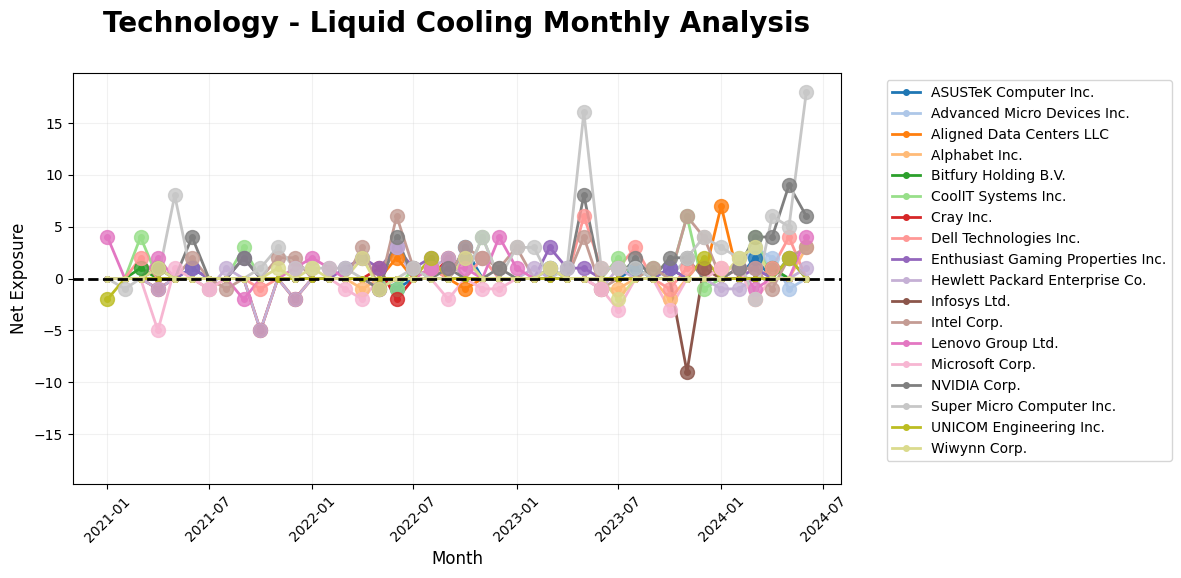

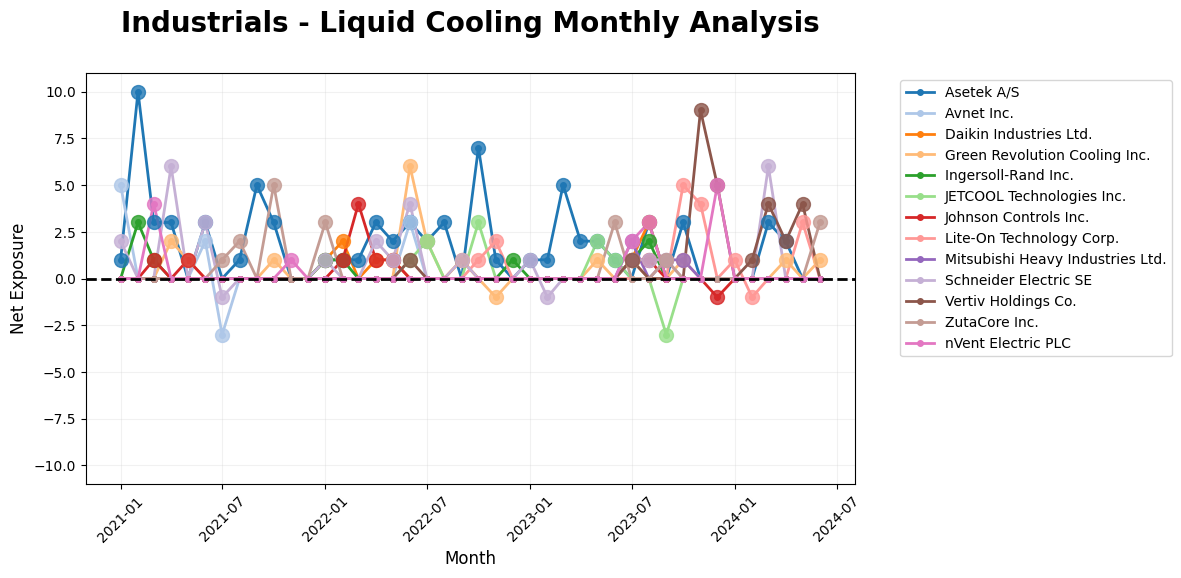

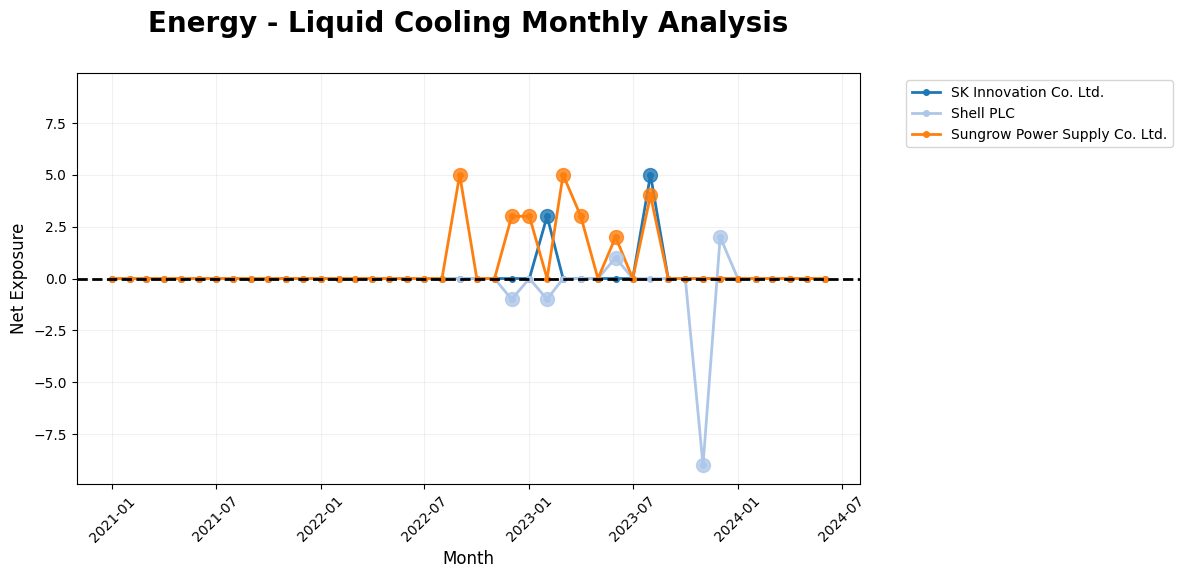

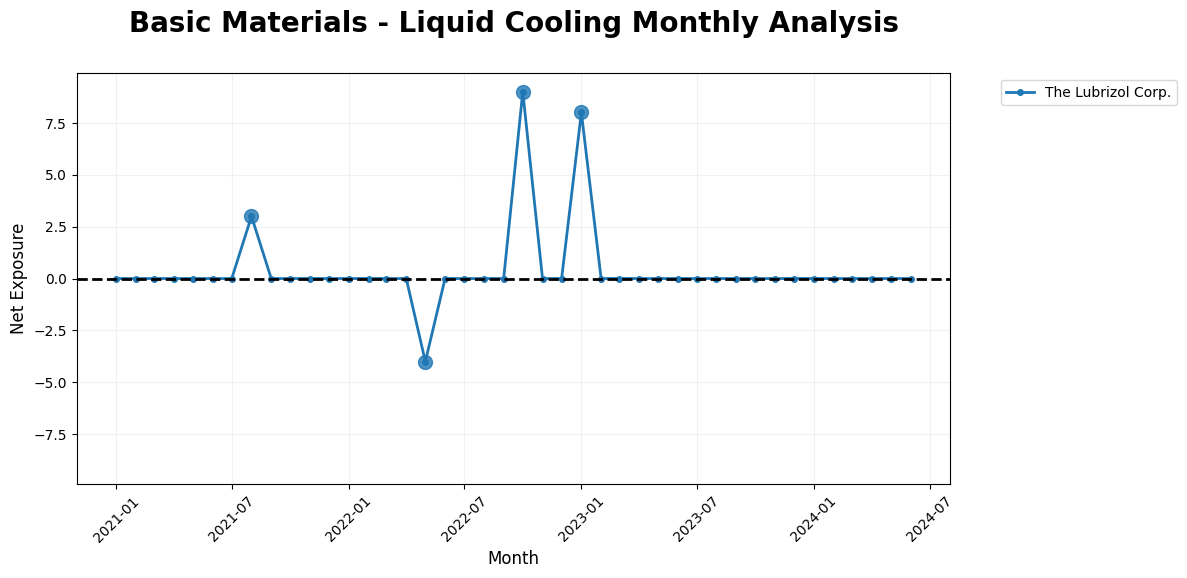

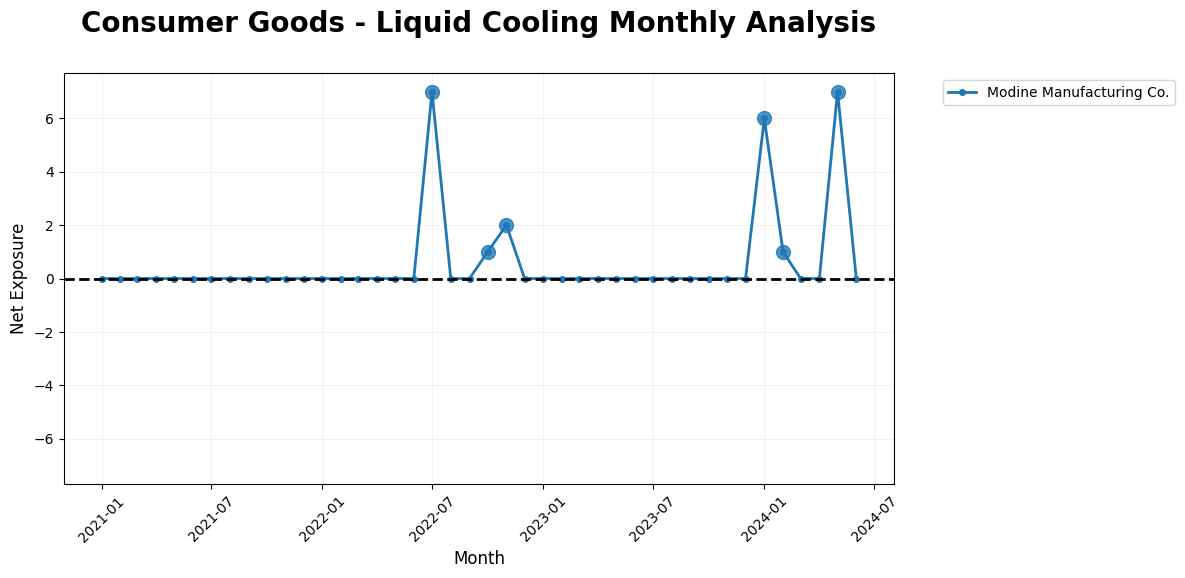

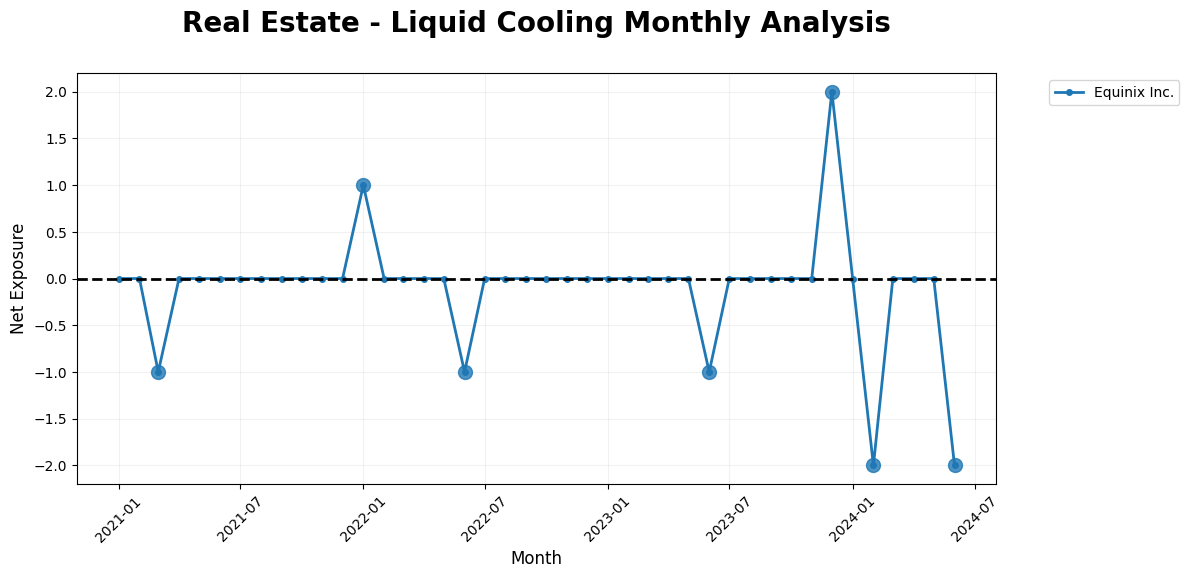

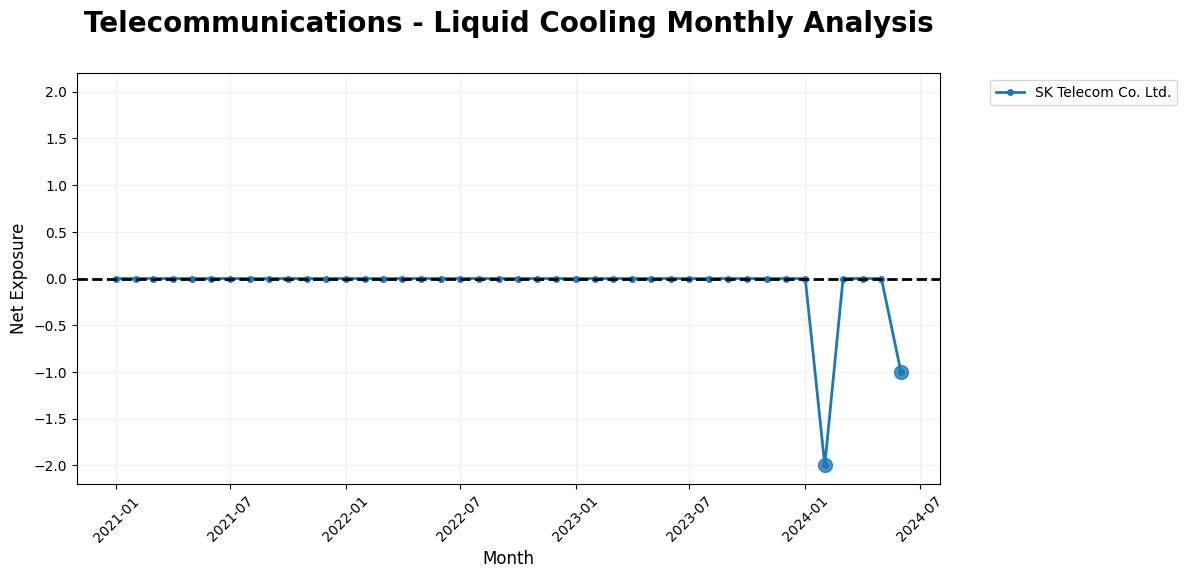

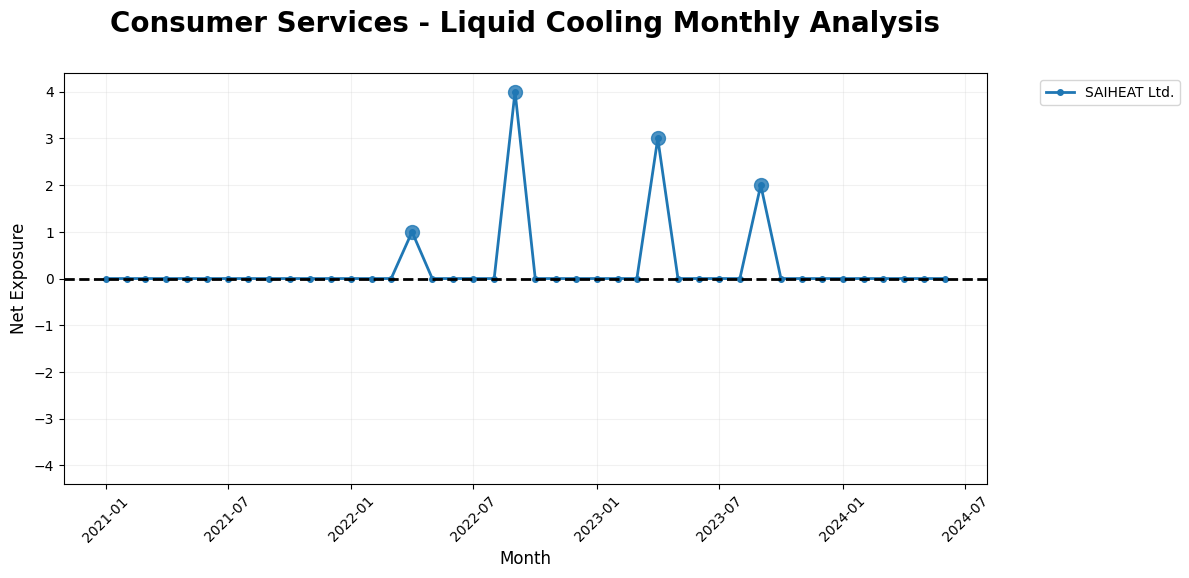

In [25]:
monthly_exposure = analyze_basket_with_labels(
    df_providers, 
    df_adopters, 
    companies_basket, 
    start_date, 
    end_date, 
    'Sector',
    theme_name='Liquid Cooling',
    interactive=True,
    frequency='monthly',
    analysis_suffix = "Monthly Analysis"
)

## Provider-Adopter Network Analysis

This network visualization reveals relationships between liquid cooling technology providers and adopters through co-mentions in news articles. The analysis identifies:

- **Technology Partnerships**: Companies that frequently appear together in liquid cooling contexts
- **Customer-Supplier Relationships**: Connections between solution providers and data center operators
- **Market Clusters**: Groups of companies operating in similar segments of the liquid cooling ecosystem

Notable partnerships that may emerge include relationships between server manufacturers and data center operators, cooling system suppliers and cloud providers, and technology developers working with early adopters to refine their solutions.

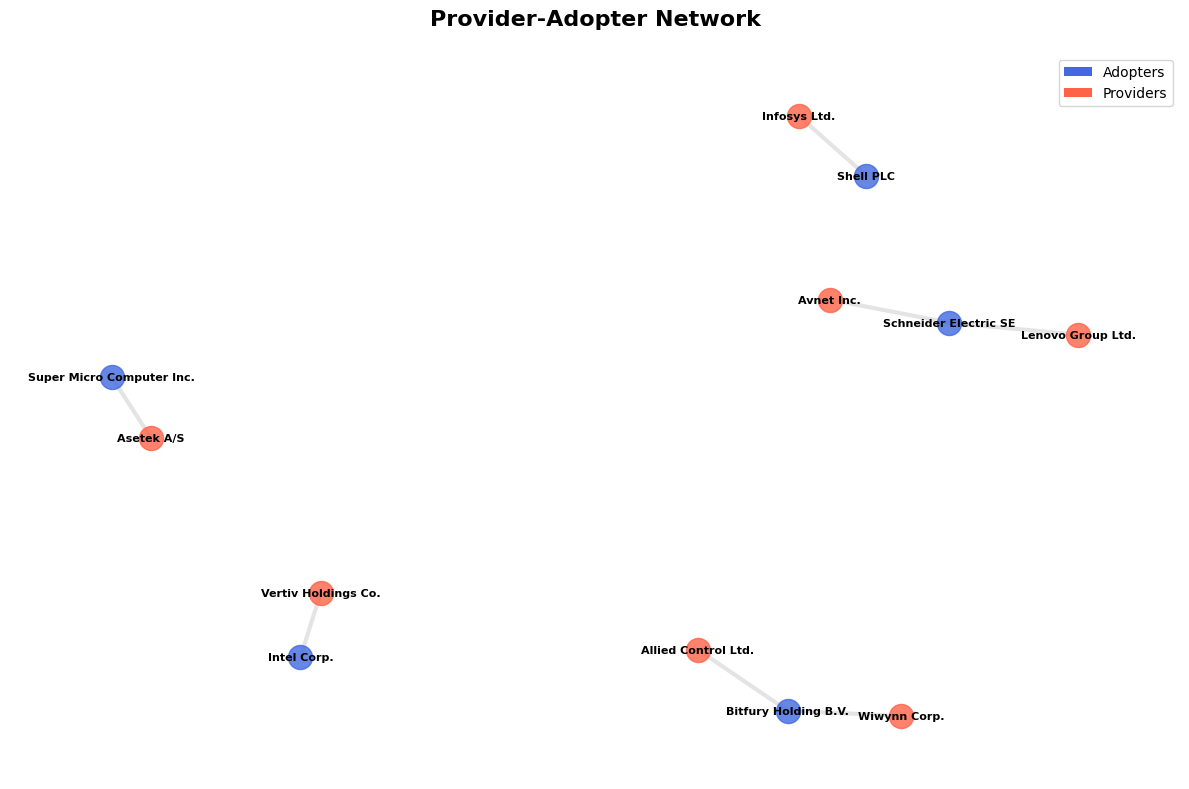

In [ ]:
fig = provider_adopter_net(
    df_filtered_adopters=df_adopters,
    df_filtered_providers=df_providers,
    bigdata_cred=None,
    min_occurrences=1, # Change this if you want to see more or less companies 
    dash=False,
    interactive=True
)

## Key Insights and Technology Stories

The liquid cooling analysis reveals several important technology adoption patterns:

**Technology Provider Leadership**: Companies like Dell, NVIDIA, and specialized cooling system manufacturers are leading the development of liquid cooling solutions, with frequent mentions of new product launches and technology partnerships.

**Data Center Operator Adoption**: Major cloud providers and data center operators are increasingly implementing liquid cooling systems to improve energy efficiency and support high-density computing workloads, particularly for AI and machine learning applications.

**Supply Chain Relationships**: The network analysis reveals emerging partnerships between cooling technology providers and data center operators, indicating the development of integrated solutions and long-term supply relationships.

**Market Evolution**: The temporal analysis shows increasing adoption momentum, with more frequent mentions of liquid cooling implementations as organizations seek to address growing energy and performance demands in modern data centers.

## Export the Results

Export the data as Excel files for further analysis or to share with the team.

In [20]:
try:
    # Create the Excel manager
    excel_manager = ExcelManager()

    # Define the dataframes and their sheet configurations
    df_args = [
        (df_providers, "Liquid Cooling Providers", (0, 0)),
        (df_adopters, "Liquid Cooling Adopters", (0, 0)),
        (companies_basket, "Technology Ecosystem Basket", (2, 4)),
        (monthly_exposure, "Monthly Exposure Analysis", (2, 2))
    ]

    # Save the workbook
    excel_manager.save_workbook(df_args, export_path)
    print(f"✅ Results exported to {export_path}")

except Exception as e:
    print(f"Warning while exporting to excel: {e}")

✅ Results exported to output/liquid_cooling_analysis_results.xlsx


In [ ]:
print("Runtime:", datetime.datetime.now() - start)